## 스프린트 미션 #8
#### 3팀 전수현 
#### 제출일자: 25.07.11

## 데이터 탐색

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /home/soohyun/.cache/kagglehub/datasets/sadhliroomyprime/football-semantic-segmentation/versions/1


## 0. Import Libraries

In [6]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 라이브러리
import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
import torchvision
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 통계 tool
import pandas as pd

# 실험 추적 및 하이퍼파라미터 관리
import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

# Garbage Collector 모듈
import gc

# Data Augmentation 패키지: Albumentations
import albumentations as A

## 1. Set configuration

In [7]:
# ====================================================================
# STEP 1: Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 주요 하이퍼파라미터
LEARNING_RATE = 1e-4  # 학습률 (optimizer용)
BATCH_SIZE = 16  # 배치 크기
NUM_EPOCHS = 100  # 학습 epoch 수
SEED = 42  # 재현성을 위한 random seed

# 데이터 경로 설정
# DATA_ROOT = path
# train_dir = os.path.join(DATA_ROOT, "train")
# val_dir = os.path.join(DATA_ROOT, "val")
# test_dir = os.path.join(DATA_ROOT, "test")

# 모델 설정
MODEL_NAME = "SSD_with_augmentation_v"  # 또는 "EfficientNet", 등등
USE_PRETRAINED = True  # torchvision 모델 사용 여부

# 학습 고도화 설정 (Optional)
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# 실험 로깅용 설정
USE_WANDB = True
WANDB_PROJECT = "cats-and-dogs-breeds-classification-oxford-dataset"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

Using device: cuda


## 2. Data pre-processing

먼저 데이터를 EDA해보면서 데이터를 파악하는 것이 우선이다. 코드잇에서 제공한 baseline코드를 바탕으로 데이터를 이해해보는 과정을 먼저 해당 노트북에 기록했다.

In [8]:
# 폴더 내 모든 파일 목록 가져오기
image_folder = os.path.join(path, "images")
file_list = os.listdir(image_folder)

# 원본 이미지(.jpg)와 fuse 이미지 매칭
original_files = sorted([f for f in file_list if f.endswith(".jpg")])
fuse_files = sorted([f for f in file_list if "fuse" in f])

# 이미지 로드 및 확인
image_pairs = []
for orig_file in original_files:
    # 동일한 프레임의 fuse 파일 찾기
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        # 원본과 마스크 로드
        img_path = os.path.join(image_folder, orig_file)
        mask_path = os.path.join(image_folder, fuse_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img is not None and mask is not None:
            image_pairs.append((img, mask))

# 최종적으로 로드된 이미지 쌍 개수 출력
print(f"{len(image_pairs)} pairs")

100 pairs


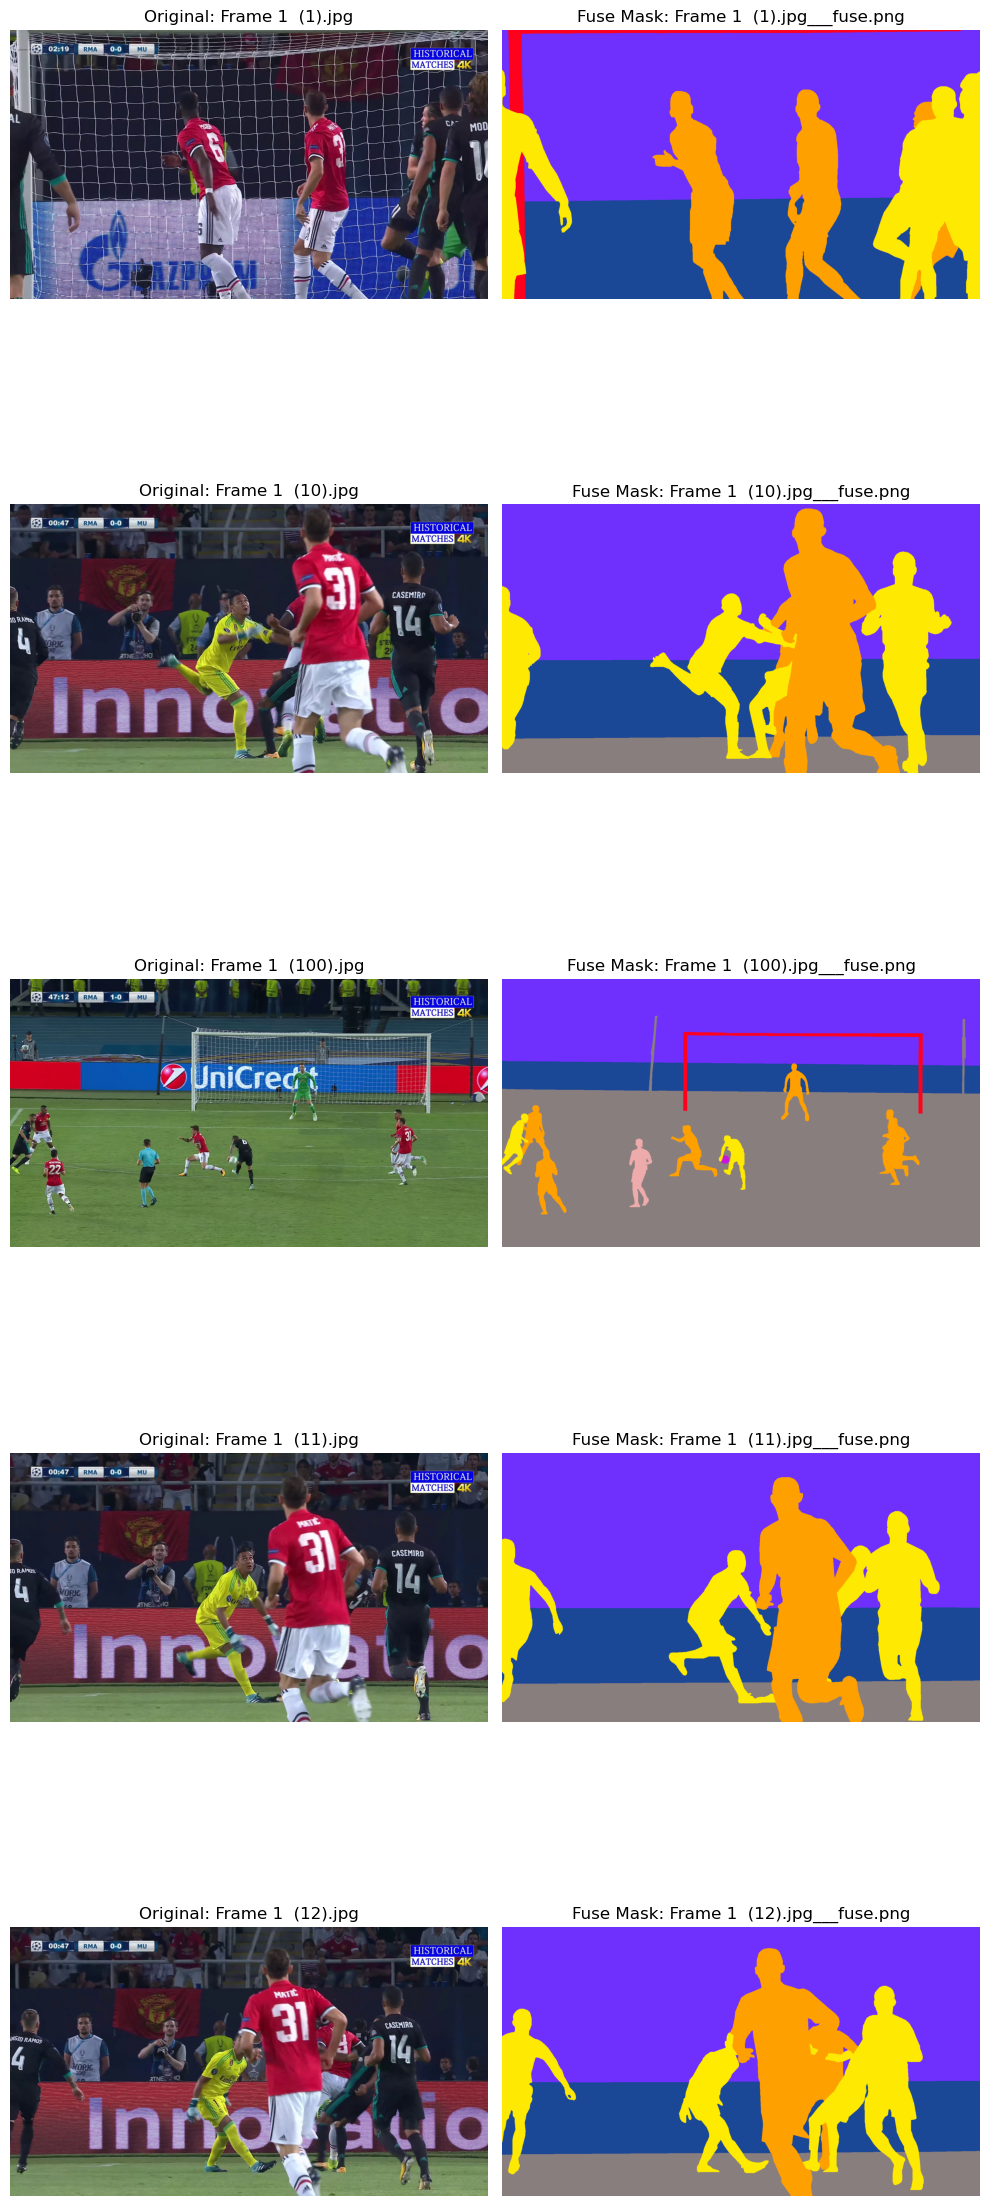

In [9]:
# 샘플 이미지 출력해보기

sample_image_pairs = []
num_samples = 5

for orig_file in original_files[:num_samples]:
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        sample_image_pairs.append((orig_file, fuse_file))

# 이미지 5쌍 시각화
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i, (orig_file, fuse_file) in enumerate(sample_image_pairs):
    # 이미지 로드
    orig_img = cv2.imread(os.path.join(image_folder, orig_file))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

    fuse_img = cv2.imread(os.path.join(image_folder, fuse_file))
    fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환

    # 시각화
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {orig_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fuse_img)
    axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# 데이터셋 전체의 고유한 색상 수집
def get_unique_colors(image_folder, mask_files, max_classes=11):
    color_set = set()

    for mask_file in mask_files:
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))  # 고유한 색상 저장

            # 클래스 개수가 max_classes개가 되면 중단
            if len(color_set) >= max_classes:
                return list(color_set)  # 최대 max_classes개까지만 반환

    return list(color_set)  # 모든 마스크를 순회 후 반환


# 모든 마스크에서 등장하는 색상 수집
unique_colors = get_unique_colors(image_folder, fuse_files)
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}

In [13]:
# 데이터셋 클래스 정의 (RGB 마스크 변환 포함)
class FootballDataset(Dataset):
    def __init__(self, image_files, mask_files, image_folder, color_to_label):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label  # 고정된 클래스 매핑

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        # 원본 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)) / 255.0  # 정규화

        # 마스크 로드 (RGB 모드)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # 고정된 color_to_label을 사용하여 클래스 변환
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            mask_class[(mask == color).all(axis=-1)] = label  # 고정된 ID 사용

        # PyTorch 텐서 변환
        img = torch.tensor(img, dtype=torch.float32).permute(
            2, 0, 1
        )  # (H, W, C) → (C, H, W)
        mask = torch.tensor(mask_class, dtype=torch.long)  # (H, W)

        return img, mask

In [ ]:
# 데이터 로드
dataset = FootballDataset(original_files, fuse_files, image_folder, color_to_label)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

print(f"Train Data: {len(train_dataset)}, Test Data: {len(test_dataset)}")

Train Data: 80, Test Data: 20


## 3. Model implementation

## 4. Train and Evaluate a model

In [ ]:
# ====================================================================
# STEP 4: train and evalutate
# ====================================================================


# 학습에 쓰일 Ealystopping 클래스
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self,
        patience=5,
        verbose=False,
        delta=0,
        path="../experiments/best_model.pth",
        trace_func=print,
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'best_model.pth'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Train 루프
def train_fn(
    model: nn.Module,
    model_name: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion,
    optimizer,
    scheduler,
    num_epochs: int,
):
    print(f"** Start training a model {model_name} ** ")
    path_model = "experiments/" + model_name + ".pt"
    early_stopping = EarlyStopping(patience=5, verbose=True, path=path_model)
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for inputs, labels in loop:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

        # train loss
        avg_train_loss = running_loss / len(train_loader)

        # 검증 단계 수행
        eval_results = evaluate(model, val_loader, criterion)

        # Learning Rate Scheduler 적용. val_loss를 고려하여 learning rate를 조정
        if USE_SCHEDULER:
            scheduler.step(eval_results["loss"])

        # EarlyStopping 로직 호출
        early_stopping(eval_results["loss"], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print(
            f"(Train Loss: {avg_train_loss:.4f} | Val Loss: {eval_results['loss']:.4f} | Val Acc: {eval_results['accuracy']:.4f})"
        )

        print("***Valset evaluation***")
        print(
            f"Accuracy: {eval_results['accuracy']:.4f} | F1-Score: {eval_results['f1_score']:.4f}, Precision: {eval_results['precision']:.4f} |  Recall: {eval_results['recall']:.4f} "
        )
    print("Loading best model weights.")
    model.load_state_dict(torch.load(path_model))

In [ ]:
MODEL_NAME = "Baseline_UNET"
criterion = nn.CrossEntropyLoss()

# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

## 5. Test Models

## 6. Results & Disscussion

## 7. Conclusion